# Imports

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
import os
from tqdm import tqdm
from copy import deepcopy
import random
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Model

In [ ]:
def coreset(x_coresets, y_coresets, x_train, y_train, size, mode='random'):
  if mode == 'centre':
    indices = [0]
    current = 0
    dists = np.full(len(x_train), np.inf)
    for i in range(1, size):
      dists = np.minimum([np.linalg.norm(x_train[j] - x_train[current]) for j in range(len(x_train))], dists)
      current = np.argmax(dists)
      indices.append(current)
  else:
    indices = np.random.choice(len(x_train), size=size, replace=False)
  x_coresets.append(x_train[indices])
  y_coresets.append(y_train[indices])
  x_train = np.delete(x_train, indices, axis = 0)
  y_train = np.delete(y_train, indices, axis = 0)
  return x_coresets, y_coresets, x_train, y_train

In [ ]:
class MFVI(nn.Module):
  def __init__(self, input_dim, layers, heads, output_dim, head, prior = None):
    super(MFVI, self).__init__()
    self.input_dim = input_dim
    self.layers = layers
    self.heads = heads
    self.output_dims = []

    self.prior = None
    self.prior_head = None
    self.posterior = None
    self.posterior_head = None
    self._init_weights(prior, head, output_dim)

  def forward(self, x, head):
    sampled_layers = []
    (w_means, w_logvars, b_means, b_logvars) = self.posterior
    for i in range(len(w_means)):
      w_epsilon = torch.randn_like(w_means[i])
      b_epsilon = torch.randn_like(b_means[i])
      sampled_layers.append((w_means[i] + w_epsilon * torch.exp(0.5*w_logvars[i]), b_means[i] + b_epsilon * torch.exp(0.5*b_logvars[i])))
    (w_means, w_logvars, b_means, b_logvars) = self.posterior_head
    i = 0
    while i < len(w_means[head])-1:
      w_epsilon = torch.randn_like(w_means[head][i])
      b_epsilon = torch.randn_like(b_means[head][i])
      sampled_layers.append((w_means[head][i] + w_epsilon * torch.exp(0.5*w_logvars[head][i]), b_means[head][i] + b_epsilon * torch.exp(0.5*b_logvars[head][i])))
      i += 1
    for layer in sampled_layers:
      x = torch.relu(x @ layer[0] + layer[1])
    w_epsilon = torch.randn_like(w_means[head][i])
    b_epsilon = torch.randn_like(b_means[head][i])
    x = x @ (w_means[head][i] + w_epsilon * torch.exp(0.5*w_logvars[head][i])) + (b_means[head][i] + b_epsilon * torch.exp(0.5*b_logvars[head][i]))
    return x

  def predict(self, x, head, num_samples = 100):
    outputs = torch.empty(num_samples, len(x), self.output_dims[head])
    for i in range(num_samples):
      outputs[i] = nn.Softmax(dim = 1)(self.forward(x, head))
    outputs = outputs.mean(dim = 0)
    return outputs

  def mle_loss(self, x, y, head):
    for i in range(len(self.posterior[0])):
      x = torch.relu(x @ self.posterior[0][i] + self.posterior[2][i])
    i = 0
    while i < len(self.posterior_head[0][head])-1:
      x = torch.relu(x @ self.posterior_head[0][head][i] + self.posterior_head[2][head][i])
      i += 1
    x = x @ self.posterior_head[0][head][i] + self.posterior_head[2][head][i]
    return nn.CrossEntropyLoss()(x, y)

  def kl_loss(self, x, y, head, size = 60000, samples = 10):
    kl = self.kl(head) / size
    log_likelihood = self.log_likelihood(x, y, head, samples)
    #print(kl, log_likelihood)
    return kl - log_likelihood

  def kl(self, head):
    prior_means = torch.cat([torch.flatten(x).to(device) for x in self.prior[0] + self.prior[2] + [elem for sublist in self.prior_head[0] for elem in sublist] + [elem for sublist in self.prior_head[2] for elem in sublist]])
    prior_logvars = torch.cat([torch.flatten(x).to(device) for x in self.prior[1] + self.prior[3] + [elem for sublist in self.prior_head[1] for elem in sublist] + [elem for sublist in self.prior_head[3] for elem in sublist]])
    prior_vars = torch.exp(prior_logvars)
    posterior_means = torch.cat([torch.flatten(x).to(device) for x in self.posterior[0] + self.posterior[2] + [elem for sublist in self.posterior_head[0] for elem in sublist] + [elem for sublist in self.posterior_head[2] for elem in sublist]])
    posterior_logvars = torch.cat([torch.flatten(x).to(device) for x in self.posterior[1] + self.posterior[3] + [elem for sublist in self.posterior_head[1] for elem in sublist] + [elem for sublist in self.posterior_head[3] for elem in sublist]])
    posterior_vars = torch.exp(posterior_logvars)
    kl_normal = prior_logvars - posterior_logvars + (posterior_vars + torch.pow(posterior_means - prior_means, 2)) / (prior_vars + 1e-8) - 1
    return torch.sum(kl_normal) * 0.5

  def log_likelihood(self, x, y, head, samples):
    outputs = []
    for i in range(samples):
      outputs.append(self.forward(x, head))
    outputs = torch.cat(outputs)
    return - nn.CrossEntropyLoss()(outputs, y.repeat(samples).view(-1))

  def _init_weights(self, prior, head, output_dim):
    parameter_mean = lambda x: nn.Parameter(torch.randn_like(x, requires_grad=True)*0.1)
    parameter_var = lambda x: nn.Parameter(torch.ones_like(x, requires_grad=True)*-6*math.log(10))

    if prior is not None:
      self.output_dims = [x[-1].shape[0] for x in prior[1][2]]
      self.prior = deepcopy(prior[0])
      self.prior_head = deepcopy(prior[1])
      self.posterior = deepcopy(prior[0])
      self.posterior_head = deepcopy(prior[1])

      if head == len(self.output_dims):
        self.output_dims.append(output_dim)
        head_params = [self.layers[-1]] + self.heads + [output_dim]

        head_w_means = [torch.zeros(head_params[i], head_params[i+1]) for i in range(len(head_params)-1)]
        head_w_logvars = [torch.zeros_like(head_w) for head_w in head_w_means]
        head_b_means = [torch.zeros(head_params[i]) for i in range(1, len(head_params))]
        head_b_logvars = [torch.zeros_like(head_b) for head_b in head_b_means]
        self.prior_head[0].append(head_w_means)
        self.prior_head[1].append(head_w_logvars)
        self.prior_head[2].append(head_b_means)
        self.prior_head[3].append(head_b_logvars)

        head_w_means = [parameter_mean(head_w) for head_w in head_w_means]
        head_w_logvars = [parameter_var(head_w) for head_w in head_w_logvars]
        head_b_means = [parameter_mean(head_b) for head_b in head_b_means]
        head_b_logvars = [parameter_var(head_b) for head_b in head_b_logvars]
        self.posterior_head[0].append(head_w_means)
        self.posterior_head[1].append(head_w_logvars)
        self.posterior_head[2].append(head_b_means)
        self.posterior_head[3].append(head_b_logvars)

      elif head < 0 or head > len(self.prior_head[0]) + 1:
        raise Exception('Invalid head')

    else:
      self.output_dims.append(output_dim)
      w_means = [torch.zeros(self.input_dim, self.layers[0])] + [torch.zeros(self.layers[i], self.layers[i+1]) for i in range(len(self.layers)-1)]
      w_logvars = [torch.zeros_like(w) for w in w_means]
      b_means = [torch.zeros(self.layers[i]) for i in range(len(self.layers))]
      b_logvars = [torch.zeros_like(b) for b in b_means]
      self.prior = (w_means, w_logvars, b_means, b_logvars)

      head_params = [self.layers[-1]] + self.heads + [output_dim]
      head_w_means = [[torch.zeros(head_params[i], head_params[i+1]) for i in range(len(head_params)-1)]]
      head_w_logvars = [[torch.zeros_like(head_w) for head_w in head] for head in head_w_means]
      head_b_means = [[torch.zeros(head_params[i]) for i in range(1, len(head_params))]]
      head_b_logvars = [[torch.zeros_like(head_b) for head_b in head] for head in head_b_means]
      self.prior_head = (head_w_means, head_w_logvars, head_b_means, head_b_logvars)

      w_means = [parameter_mean(w) for w in self.prior[0]]
      w_logvars = [parameter_var(w) for w in self.prior[1]]
      b_means = [parameter_mean(b) for b in self.prior[2]]
      b_logvars = [parameter_var(b) for b in self.prior[3]]
      self.posterior = (w_means, w_logvars, b_means, b_logvars)

      head_w_means = [[parameter_mean(head_w) for head_w in head] for head in self.prior_head[0]]
      head_w_logvars = [[parameter_var(head_w) for head_w in head] for head in self.prior_head[1]]
      head_b_means = [[parameter_mean(head_b) for head_b in head] for head in self.prior_head[2]]
      head_b_logvars = [[parameter_var(head_b) for head_b in head] for head in self.prior_head[3]]
      self.posterior_head = (head_w_means, head_w_logvars, head_b_means, head_b_logvars)

    for i in range(len(self.prior[0])):
      self.register_buffer(f'w_means_{i}', self.prior[0][i])
      self.register_buffer(f'w_logvars_{i}', self.prior[1][i])
      self.register_buffer(f'b_means_{i}', self.prior[2][i])
      self.register_buffer(f'b_logvars_{i}', self.prior[3][i])

    for i in range(len(self.prior_head[0])):
      for j in range(len(self.prior_head[0][i])):
        self.register_buffer(f'head_w_means_{i}_{j}', self.prior_head[0][i][j])
        self.register_buffer(f'head_w_logvars_{i}_{j}', self.prior_head[1][i][j])
        self.register_buffer(f'head_b_means_{i}_{j}', self.prior_head[2][i][j])
        self.register_buffer(f'head_b_logvars_{i}_{j}', self.prior_head[3][i][j])

    for i in range(len(self.posterior[0])):
      self.register_parameter(f'post_w_means_{i}', self.posterior[0][i])
      self.register_parameter(f'post_w_logvars_{i}', self.posterior[1][i])
      self.register_parameter(f'post_b_means_{i}', self.posterior[2][i])
      self.register_parameter(f'post_b_logvars_{i}', self.posterior[3][i])

    for i in range(len(self.posterior_head[0])):
      for j in range(len(self.posterior_head[0][i])):
        self.register_parameter(f'post_head_w_means_{i}_{j}', self.posterior_head[0][i][j])
        self.register_parameter(f'post_head_w_logvars_{i}_{j}', self.posterior_head[1][i][j])
        self.register_parameter(f'post_head_b_means_{i}_{j}', self.posterior_head[2][i][j])
        self.register_parameter(f'post_head_b_logvars_{i}_{j}', self.posterior_head[3][i][j])

# Train and test

In [ ]:
from torch.utils.data import Dataset, DataLoader
class numpy_dataset(Dataset):  # Inherit from Dataset class
    def __init__(self, data, target):
        ## Add code here
        self.data = torch.from_numpy(data)
        self.target = torch.from_numpy(target)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        return x, y

    def __len__(self):
        return len(self.data)

In [ ]:
def train_model(model, x_train, y_train, loss_fn, head, lr=1e-3, epochs=100, batch_size=256):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_dataset = numpy_dataset(x_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True)
    progress = tqdm(range(epochs), 'Epochs: ')
    for epoch in progress:
        correct = 0
        total = 0
        for batch_idx, (x_data, y_data) in enumerate(train_loader):
          x_data, y_data = x_data.to(device), y_data.to(device)
          optimizer.zero_grad()
          loss = loss_fn(x_data, y_data, head)
          loss.backward()
          optimizer.step()

          y_pred = model(x_data, head)
          _, predicted = torch.max(y_pred.data, 1)
          total += y_data.size(0)
          correct += (predicted == y_data).sum().item()

        progress.set_postfix_str(f'Loss: {loss.item():.4f}, Acc: {correct/total:.4f}')
    return model

In [ ]:
def coreset_train_model(model, x_coresets, y_coresets, loss_fn, single_head, lr=1e-3, epochs=100, batch_size=256):
    if len(x_coresets) == 0:
      return model
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_datasets = [numpy_dataset(x_coresets[i], y_coresets[i]) for i in range(len(x_coresets))]
    train_loaders = [DataLoader(train_dataset, batch_size=batch_size, shuffle = True) for train_dataset in train_datasets]
    tasks = [i for i in range(len(x_coresets))]
    progress = tqdm(range(epochs), 'Epochs: ')
    for epoch in progress:
        random.shuffle(tasks)
        correct = 0
        total = 0
        for task in tasks:
          train_loader = train_loaders[task]
          head = 0 if single_head else task
          for batch_idx, (x_data, y_data) in enumerate(train_loader):
            x_data, y_data = x_data.to(device), y_data.to(device)
            optimizer.zero_grad()
            loss = loss_fn(x_data, y_data, head, len(x_coresets[task]))
            loss.backward()
            optimizer.step()

            y_pred = model(x_data, head)
            _, predicted = torch.max(y_pred.data, 1)
            total += y_data.size(0)
            correct += (predicted == y_data).sum().item()

        progress.set_postfix_str(f'Loss: {loss.item():.4f}, Acc: {correct/total:.4f}')
    return model

In [ ]:
def test_model(model, test_data, head, x_core, y_core, l = "cat"):
  model.eval()
  correct = 0
  total = 0
  test = numpy_dataset(test_data[0], test_data[1])
  test_loader = DataLoader(test, batch_size=len(test_data[0]))
  with torch.no_grad():
    for batch_idx, (x_data, y_data) in enumerate(test_loader):
      x_data, y_data = x_data.to(device), y_data.to(device)
      y_pred = model.predict(x_data, head).to(device)
      _, predicted = torch.max(y_pred.data, 1)
      if l == "cat":
        loss = torch.sqrt(nn.MSELoss()(y_pred, F.one_hot(y_data)))
        correct += (predicted == y_data).sum().item()
      else:
        loss = torch.sqrt(nn.MSELoss()(y_pred, y_data))
        correct += (predicted == y_data).sum().item()
      total += y_data.size(0)

  return correct, total, loss.item()

# VCL

In [ ]:
def vcl(layers, heads, epochs, data, mode, size, batch_size, single_head):
  in_dim, out_dim = data.get_dims()
  x_coresets = []
  y_coresets = []
  accuracy = []
  test_sets = []
  model = MFVI(in_dim, layers, heads, out_dim, 0).to(device)
  for i in range(data.max_iter):
    print(f'Task {i + 1}')
    x_train, y_train, x_test, y_test = data.next_task()
    test_sets.append([x_test, y_test])

    head = 0 if single_head else i
    if i == 0:
      model = train_model(model, x_train, y_train, model.mle_loss, head, epochs=epochs, batch_size=batch_size)
    if size > 0:
      x_coresets, y_coresets, x_train, y_train = coreset(x_coresets, y_coresets, x_train, y_train, size, mode=mode)
    if i != 0:
      model = MFVI(in_dim, layers, heads, out_dim, head, (model.posterior, model.posterior_head)).to(device)
    model = train_model(model, x_train, y_train, lambda x, y, z: model.kl_loss(x, y, z, len(x_train)), head, epochs=epochs, batch_size=batch_size)

    pred_model = MFVI(in_dim, layers, heads, out_dim, head, (model.posterior, model.posterior_head)).to(device)
    pred_model = coreset_train_model(pred_model, x_coresets, y_coresets, pred_model.kl_loss, single_head, epochs=epochs, batch_size=batch_size)

    acc_iter = {}
    all = (0,0)
    losses = 0
    for j, test in enumerate(test_sets):
      h = 0 if single_head else j
      correct, total, loss = test_model(pred_model, test, h, x_coresets, y_coresets)
      acc_iter[j] = [correct/total, loss]
      all = (all[0]+correct, all[1]+total)
      losses += loss*total
      print(f'Loss = {loss}, Accuracy: {correct/total}', end='\n' if j == len(test_sets)-1 else ', ')
    acc_iter['all'] = [all[0]/all[1], losses/all[1]]
    print(f'Loss = {losses/all[1]}, Accuracy: {all[0]/all[1]}')
    accuracy.append(acc_iter)
  return accuracy

# Generators

In [ ]:
from copy import deepcopy
from torchvision.datasets import MNIST
import torchvision.transforms as T

In [ ]:
class PermutedMnistGenerator():
    def __init__(self, max_iter=10):
        mnist_trainset = MNIST(root='./data', train=True, download=True)
        mnist_testset = MNIST(root='./data', train=False, download=True)
        self.X_train = mnist_trainset.data.numpy().astype(np.float32).reshape(-1, 28*28)/255
        self.Y_train = mnist_trainset.targets.numpy()
        self.X_test = mnist_testset.data.numpy().astype(np.float32).reshape(-1, 28*28)/255
        self.Y_test = mnist_testset.targets.numpy()
        self.max_iter = max_iter
        self.cur_iter = 0

    def get_dims(self):
        # Get data input and output dimensions
        return 28*28, 10

    def next_task(self):
        if self.cur_iter >= self.max_iter:
            raise Exception('Number of tasks exceeded!')
        else:
            permutation = torch.randperm(784)
            # Retrieve train data
            next_x_train = deepcopy(self.X_train)
            next_x_train = next_x_train[:,permutation]
            next_y_train = deepcopy(self.Y_train)

            # Retrieve test data
            next_x_test = deepcopy(self.X_test)
            next_x_test = next_x_test[:,permutation]
            next_y_test = deepcopy(self.Y_test)

            self.cur_iter += 1

            return next_x_train, next_y_train, next_x_test, next_y_test

In [ ]:
class SplitMnistGenerator():
    def __init__(self, max_iter=5):
        mnist_trainset = MNIST(root='./data', train=True, download=True)
        mnist_testset = MNIST(root='./data', train=False, download=True)
        trainsets = [[] for i in range(10)]
        for i in range(len(mnist_trainset.targets)):
          trainsets[mnist_trainset.targets[i]].append(i)
        testsets = [[] for i in range(10)]
        for i in range(len(mnist_testset.targets)):
          testsets[mnist_testset.targets[i]].append(i)

        self.X_train = mnist_trainset.data.numpy().astype(np.float32).reshape(-1, 28*28)/255
        self.Y_train = mnist_trainset.targets.numpy() % 2
        self.X_test = mnist_testset.data.numpy().astype(np.float32).reshape(-1, 28*28)/255
        self.Y_test = mnist_testset.targets.numpy() % 2
        self.X_trains = [self.X_train[trainsets[i]] for i in range(10)]
        self.Y_trains = [self.Y_train[trainsets[i]] for i in range(10)]
        self.X_tests = [self.X_test[testsets[i]] for i in range(10)]
        self.Y_tests = [self.Y_test[testsets[i]] for i in range(10)]
        self.max_iter = max_iter
        self.cur_iter = 0

    def get_dims(self):
        # Get data input and output dimensions
        return 28*28, 2

    def next_task(self):
        if self.cur_iter >= self.max_iter:
            raise Exception('Number of tasks exceeded!')
        else:
          next_x_train = np.concat(self.X_trains[self.cur_iter*2:self.cur_iter*2+2])
          next_y_train = np.concat(self.Y_trains[self.cur_iter*2:self.cur_iter*2+2])
          next_x_test = np.concat(self.X_tests[self.cur_iter*2:self.cur_iter*2+2])
          next_y_test = np.concat(self.Y_tests[self.cur_iter*2:self.cur_iter*2+2])

          self.cur_iter += 1
          return next_x_train, next_y_train, next_x_test, next_y_test



In [ ]:
class SplitNotMnistGenerator():
    def __init__(self, max_iter=5):
        path = "/content/drive/MyDrive/notMNIST/train"
        dirs = os.listdir( path )
        dirs.sort()

        self.X_trains = [0 for _ in range(10)]
        self.Y_trains = [0 for _ in range(10)]
        self.X_tests =  [0 for _ in range(10)]
        self.Y_tests =  [0 for _ in range(10)]

        for i in range(len(dirs)):
          x = np.load(path+"/"+dirs[i]).astype(np.float32).reshape(-1, 28*28)/255
          y = np.full(x.shape[0], i // 5)
          self.X_trains[i] = np.array(x)
          self.Y_trains[i] = np.array(y)

        path = "/content/drive/MyDrive/notMNIST/test"
        dirs = os.listdir( path )
        dirs.sort()

        for i in range(len(dirs)):
          x = np.load(path+"/"+dirs[i]).astype(np.float32).reshape(-1, 28*28)/255
          y = np.full(x.shape[0], i // 5)
          self.X_tests[i] = np.array(x)
          self.Y_tests[i] = np.array(y)

        self.max_iter = max_iter
        self.cur_iter = 0

    def get_dims(self):
        # Get data input and output dimensions
        return 28*28, 2

    def next_task(self):
        if self.cur_iter >= self.max_iter:
            raise Exception('Number of tasks exceeded!')
        else:
          next_x_train = np.concat(self.X_trains[self.cur_iter::5])
          next_y_train = np.concat(self.Y_trains[self.cur_iter::5])
          next_x_test = np.concat(self.X_tests[self.cur_iter::5])
          next_y_test = np.concat(self.Y_tests[self.cur_iter::5])

          self.cur_iter += 1
          return next_x_train, next_y_train, next_x_test, next_y_test


In [ ]:
from datetime import datetime

def save_result(vcl_result, task, epochs, size, mode, hidden_size, heads, method):
  if not os.path.exists(f'/content/drive/MyDrive/logs/'):
    os.makedirs(f'/content/drive/MyDrive/logs/')
  with open(f'/content/drive/MyDrive/logs/{task}_{epochs}_{size}_{mode}_{datetime.now().strftime("%Y-%m-%d_%H:%M:%S")}.txt', 'w') as f:
    f.write(f'hidden_size: {hidden_size}\n')
    f.write(f'heads: {heads}\n')
    f.write(f'method: {method}\n')
    for result in vcl_result:
      f.write(f"{result}\n")

# Experiments

In [ ]:
def permutedMNIST(epochs, coreset_size, mode, version, ):
    if version == 1:
      hidden_size = [100]
      heads = [10]
    else:
      hidden_size = [100, 100]
      heads = []
    batch_size = 256
    single_head = False

    data_gen = PermutedMnistGenerator(10)
    vcl_result = vcl(hidden_size, heads, epochs, data_gen, mode, coreset_size, batch_size, single_head)
    print(vcl_result)
    save_result(vcl_result, 'permutedMNIST', epochs, coreset_size, mode, hidden_size, heads, 'categorical')

    for i in range(10):
      plt.plot([x for x in range(i,10)], [result[i][0] for result in vcl_result if i in result])
    plt.plot([x for x in range(10)], [result['all'][0] for result in vcl_result])
    plt.show()

In [ ]:
def splitMNIST(epochs, coreset_size, mode, version):
    if version == 1:
      hidden_size = [256]
      heads = [51]
    else:
      hidden_size = [256, 256]
      heads = []
    batch_size = 256
    single_head = False

    data_gen = SplitMnistGenerator(5)
    vcl_result = vcl(hidden_size, heads, epochs, data_gen, mode, coreset_size, batch_size, single_head)
    print(vcl_result)
    save_result(vcl_result, 'splitMNIST', epochs, coreset_size, mode, hidden_size, heads, 'categorical')

    for i in range(5):
      plt.plot([x for x in range(i,5)], [result[i][0] for result in vcl_result if i in result])
    plt.plot([x for x in range(5)], [result['all'][0] for result in vcl_result])
    plt.show()

In [ ]:
def splitnotMNIST(epochs, coreset_size, mode, version):
    if version == 1:
      hidden_size = [150, 150, 150]
      heads = [30]
    else:
      hidden_size = [150, 150, 150, 150]
      heads = []
    batch_size = 256
    single_head = False

    data_gen = SplitNotMnistGenerator(5)
    vcl_result = vcl(hidden_size, heads, epochs, data_gen, mode, coreset_size, batch_size, single_head)
    print(vcl_result)
    save_result(vcl_result, 'splitnotMNIST', epochs, coreset_size, mode, hidden_size, heads, 'categorical')

    for i in range(5):
      plt.plot([x for x in range(i,5)], [result[i][0] for result in vcl_result if i in result])
    plt.plot([x for x in range(5)], [result['all'][0] for result in vcl_result])
    plt.show()

# Permuted MNIST

In [ ]:
permutedMNIST(100, 0, 'random', 0)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.09MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 135kB/s]


KeyboardInterrupt: 

In [ ]:
permutedMNIST(100, 200, 'random', 0)

In [ ]:
permutedMNIST(100, 200, 'centre', 0)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 484kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.44MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.68MB/s]


Task 1


Epochs: 100%|██████████| 100/100 [07:58<00:00,  4.78s/it, Loss: 0.3089, Acc: 0.9708]


Loss = 0.05675765872001648, Accuracy: 0.9802
Loss = 0.05675765872001648, Accuracy: 0.9802
Task 2


Epochs: 100%|██████████| 100/100 [08:06<00:00,  4.87s/it, Loss: 0.3257, Acc: 0.9629]


Loss = 0.05892927572131157, Accuracy: 0.9789, Loss = 0.06427039951086044, Accuracy: 0.9744
Loss = 0.061599837616086006, Accuracy: 0.97665
Task 3


Epochs: 100%|██████████| 100/100 [08:12<00:00,  4.93s/it, Loss: 0.2067, Acc: 0.9622]


Loss = 0.061527326703071594, Accuracy: 0.9773, Loss = 0.06766737997531891, Accuracy: 0.9727, Loss = 0.06452728807926178, Accuracy: 0.9749
Loss = 0.06457399825255077, Accuracy: 0.9749666666666666
Task 4


Epochs: 100%|██████████| 100/100 [08:24<00:00,  5.05s/it, Loss: 0.2022, Acc: 0.9626]


Loss = 0.06447187811136246, Accuracy: 0.9738, Loss = 0.0701950341463089, Accuracy: 0.9696, Loss = 0.07010407745838165, Accuracy: 0.97, Loss = 0.06643159687519073, Accuracy: 0.9726
Loss = 0.06780064664781094, Accuracy: 0.9715
Task 5


Epochs: 100%|██████████| 100/100 [08:35<00:00,  5.16s/it, Loss: 0.2797, Acc: 0.9614]


Loss = 0.06480561941862106, Accuracy: 0.9737, Loss = 0.07318374514579773, Accuracy: 0.9667, Loss = 0.07332640886306763, Accuracy: 0.9664, Loss = 0.0678526908159256, Accuracy: 0.9711, Loss = 0.0669640451669693, Accuracy: 0.9726
Loss = 0.06922650188207627, Accuracy: 0.9701
Task 6


Epochs: 100%|██████████| 100/100 [08:41<00:00,  5.22s/it, Loss: 0.2080, Acc: 0.9625]


Loss = 0.06727621704339981, Accuracy: 0.9714, Loss = 0.07497868686914444, Accuracy: 0.965, Loss = 0.07447279244661331, Accuracy: 0.9657, Loss = 0.07223176211118698, Accuracy: 0.9677, Loss = 0.07165969908237457, Accuracy: 0.9679, Loss = 0.0670824870467186, Accuracy: 0.9707
Loss = 0.07128360743323962, Accuracy: 0.9680666666666666
Task 7


Epochs: 100%|██████████| 100/100 [08:56<00:00,  5.36s/it, Loss: 0.2233, Acc: 0.9599]


Loss = 0.06637191027402878, Accuracy: 0.9728, Loss = 0.07863748073577881, Accuracy: 0.9595, Loss = 0.07379017770290375, Accuracy: 0.966, Loss = 0.07445915043354034, Accuracy: 0.9668, Loss = 0.07437358051538467, Accuracy: 0.9648, Loss = 0.07143436372280121, Accuracy: 0.9676, Loss = 0.06862519681453705, Accuracy: 0.9719
Loss = 0.07252740859985352, Accuracy: 0.9670571428571428
Task 8


Epochs: 100%|██████████| 100/100 [09:08<00:00,  5.49s/it, Loss: 0.2759, Acc: 0.9602]


Loss = 0.06778668612241745, Accuracy: 0.9712, Loss = 0.08224412053823471, Accuracy: 0.956, Loss = 0.07616265118122101, Accuracy: 0.9634, Loss = 0.07564550638198853, Accuracy: 0.966, Loss = 0.07500549405813217, Accuracy: 0.9639, Loss = 0.07439614832401276, Accuracy: 0.9648, Loss = 0.07103445380926132, Accuracy: 0.9694, Loss = 0.0686710998415947, Accuracy: 0.9712
Loss = 0.07386827003210783, Accuracy: 0.9657375
Task 9


Epochs: 100%|██████████| 100/100 [09:13<00:00,  5.54s/it, Loss: 0.2605, Acc: 0.9596]


Loss = 0.07069028913974762, Accuracy: 0.9678, Loss = 0.08692912012338638, Accuracy: 0.9522, Loss = 0.08016403019428253, Accuracy: 0.9602, Loss = 0.08045920729637146, Accuracy: 0.9597, Loss = 0.0774637907743454, Accuracy: 0.9619, Loss = 0.07876887172460556, Accuracy: 0.9585, Loss = 0.07422253489494324, Accuracy: 0.9649, Loss = 0.0727437287569046, Accuracy: 0.967, Loss = 0.06994631886482239, Accuracy: 0.9698
Loss = 0.07682087686326769, Accuracy: 0.9624444444444444
Task 10


Epochs: 100%|██████████| 100/100 [09:28<00:00,  5.68s/it, Loss: 0.2264, Acc: 0.9594]


Loss = 0.07546696811914444, Accuracy: 0.962, Loss = 0.08928822726011276, Accuracy: 0.949, Loss = 0.08103826642036438, Accuracy: 0.9584, Loss = 0.08382636308670044, Accuracy: 0.9546, Loss = 0.08373481780290604, Accuracy: 0.9566, Loss = 0.0872543603181839, Accuracy: 0.9504, Loss = 0.07584831118583679, Accuracy: 0.9619, Loss = 0.07796037197113037, Accuracy: 0.9608, Loss = 0.07242287695407867, Accuracy: 0.9668, Loss = 0.07040099054574966, Accuracy: 0.9693
Loss = 0.07972415536642075, Accuracy: 0.95898
[{0: [0.9802, 0.05675765872001648], 'all': [0.9802, 0.05675765872001648]}, {0: [0.9789, 0.05892927572131157], 1: [0.9744, 0.06427039951086044], 'all': [0.97665, 0.061599837616086006]}, {0: [0.9773, 0.061527326703071594], 1: [0.9727, 0.06766737997531891], 2: [0.9749, 0.06452728807926178], 'all': [0.9749666666666666, 0.06457399825255077]}, {0: [0.9738, 0.06447187811136246], 1: [0.9696, 0.0701950341463089], 2: [0.97, 0.07010407745838165], 3: [0.9726, 0.06643159687519073], 'all': [0.9715, 0.067800

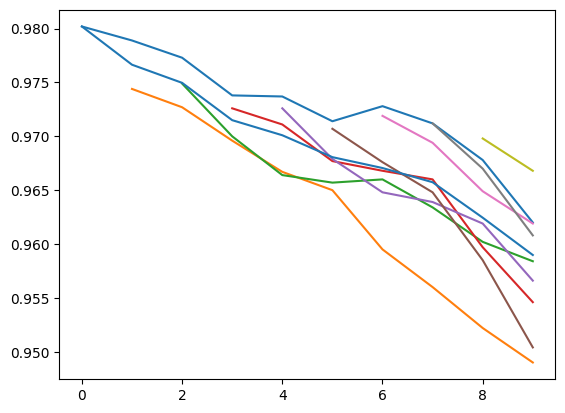

In [ ]:
permutedMNIST(100, 0, 'random', 1)

Task 1


Epochs: 100%|██████████| 100/100 [00:02<00:00, 46.02it/s, Loss: 0.0785, Acc: 0.9900]


Loss = 0.057649679481983185, Accuracy: 0.9789
Loss = 0.057649679481983185, Accuracy: 0.9789
Task 2


Epochs: 100%|██████████| 100/100 [00:04<00:00, 24.16it/s, Loss: 0.1047, Acc: 0.9725]


Loss = 0.06128370761871338, Accuracy: 0.9758, Loss = 0.06327169388532639, Accuracy: 0.977
Loss = 0.06227770075201988, Accuracy: 0.9764
Task 3


Epochs: 100%|██████████| 100/100 [00:05<00:00, 18.13it/s, Loss: 0.0869, Acc: 0.9783]


Loss = 0.06231970340013504, Accuracy: 0.9754, Loss = 0.06578006595373154, Accuracy: 0.9746, Loss = 0.06552725285291672, Accuracy: 0.9746
Loss = 0.06454234073559444, Accuracy: 0.9748666666666667
Task 4


Epochs: 100%|██████████| 100/100 [00:07<00:00, 13.65it/s, Loss: 0.1482, Acc: 0.9650]


Loss = 0.06340386718511581, Accuracy: 0.9747, Loss = 0.06756378710269928, Accuracy: 0.9737, Loss = 0.06797539442777634, Accuracy: 0.9713, Loss = 0.06458739936351776, Accuracy: 0.9749
Loss = 0.0658826120197773, Accuracy: 0.97365
Task 5


Epochs: 100%|██████████| 100/100 [00:10<00:00,  9.85it/s, Loss: 0.0964, Acc: 0.9610]


Loss = 0.06375446915626526, Accuracy: 0.9747, Loss = 0.0693686306476593, Accuracy: 0.9714, Loss = 0.07195146381855011, Accuracy: 0.9672, Loss = 0.06761268526315689, Accuracy: 0.9719, Loss = 0.06478291749954224, Accuracy: 0.9756
Loss = 0.06749403327703477, Accuracy: 0.97216
Task 6


Epochs: 100%|██████████| 100/100 [00:14<00:00,  7.05it/s, Loss: 0.1521, Acc: 0.9575]


Loss = 0.06649169325828552, Accuracy: 0.9707, Loss = 0.07471172511577606, Accuracy: 0.9668, Loss = 0.07391702383756638, Accuracy: 0.9644, Loss = 0.07039406150579453, Accuracy: 0.9687, Loss = 0.06712955236434937, Accuracy: 0.9721, Loss = 0.06697108596563339, Accuracy: 0.9719
Loss = 0.06993585700790088, Accuracy: 0.9691
Task 7


Epochs: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s, Loss: 0.1865, Acc: 0.9586]


Loss = 0.06722678989171982, Accuracy: 0.9711, Loss = 0.07738985121250153, Accuracy: 0.9628, Loss = 0.07451842725276947, Accuracy: 0.9631, Loss = 0.07808844745159149, Accuracy: 0.9613, Loss = 0.07009933888912201, Accuracy: 0.9696, Loss = 0.06946097314357758, Accuracy: 0.9703, Loss = 0.06994888186454773, Accuracy: 0.969
Loss = 0.0723903871008328, Accuracy: 0.9667428571428571
Task 8


Epochs: 100%|██████████| 100/100 [00:16<00:00,  6.00it/s, Loss: 0.1209, Acc: 0.9519]


Loss = 0.07032248377799988, Accuracy: 0.9682, Loss = 0.08033113181591034, Accuracy: 0.959, Loss = 0.0796784833073616, Accuracy: 0.9569, Loss = 0.07998012751340866, Accuracy: 0.9585, Loss = 0.0731673538684845, Accuracy: 0.9654, Loss = 0.07111014425754547, Accuracy: 0.9675, Loss = 0.07134354114532471, Accuracy: 0.9679, Loss = 0.06959237903356552, Accuracy: 0.9706
Loss = 0.07444070558995008, Accuracy: 0.96425
Task 9


Epochs: 100%|██████████| 100/100 [00:19<00:00,  5.13it/s, Loss: 0.1890, Acc: 0.9422]


Loss = 0.07053328305482864, Accuracy: 0.968, Loss = 0.08579997718334198, Accuracy: 0.9542, Loss = 0.08953779935836792, Accuracy: 0.9467, Loss = 0.08393123000860214, Accuracy: 0.9546, Loss = 0.07619192451238632, Accuracy: 0.9632, Loss = 0.07214758545160294, Accuracy: 0.9676, Loss = 0.07456402480602264, Accuracy: 0.9654, Loss = 0.07091939449310303, Accuracy: 0.9696, Loss = 0.0706903338432312, Accuracy: 0.9693
Loss = 0.07714617252349854, Accuracy: 0.9620666666666666
Task 10


Epochs: 100%|██████████| 100/100 [00:21<00:00,  4.64it/s, Loss: 0.1882, Acc: 0.9410]


Loss = 0.07451523095369339, Accuracy: 0.9645, Loss = 0.0887090265750885, Accuracy: 0.9496, Loss = 0.0944996178150177, Accuracy: 0.939, Loss = 0.08682791143655777, Accuracy: 0.9512, Loss = 0.08564947545528412, Accuracy: 0.9514, Loss = 0.07605826109647751, Accuracy: 0.9636, Loss = 0.08014505356550217, Accuracy: 0.9581, Loss = 0.07860031723976135, Accuracy: 0.9622, Loss = 0.07282762229442596, Accuracy: 0.9668, Loss = 0.0726984441280365, Accuracy: 0.9664
Loss = 0.0810530960559845, Accuracy: 0.95728
[{0: [0.9789, 0.057649679481983185], 'all': [0.9789, 0.057649679481983185]}, {0: [0.9758, 0.06128370761871338], 1: [0.977, 0.06327169388532639], 'all': [0.9764, 0.06227770075201988]}, {0: [0.9754, 0.06231970340013504], 1: [0.9746, 0.06578006595373154], 2: [0.9746, 0.06552725285291672], 'all': [0.9748666666666667, 0.06454234073559444]}, {0: [0.9747, 0.06340386718511581], 1: [0.9737, 0.06756378710269928], 2: [0.9713, 0.06797539442777634], 3: [0.9749, 0.06458739936351776], 'all': [0.97365, 0.065882

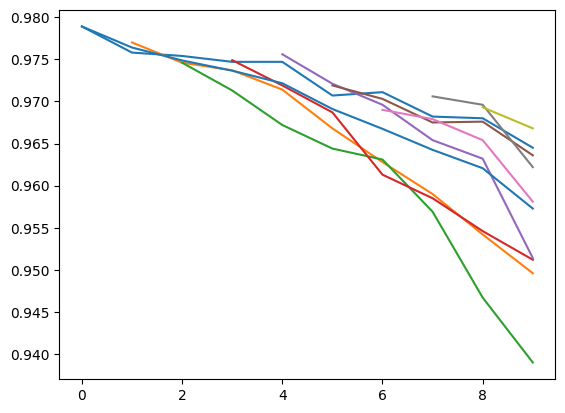

In [ ]:
permutedMNIST(100, 200, 'random', 1)

Task 1


Epochs: 100%|██████████| 100/100 [00:01<00:00, 54.31it/s, Loss: 0.5153, Acc: 0.9000]


Loss = 0.05833209306001663, Accuracy: 0.9806
Loss = 0.05833209306001663, Accuracy: 0.9806
Task 2


Epochs: 100%|██████████| 100/100 [00:03<00:00, 27.82it/s, Loss: 0.5812, Acc: 0.8400]


Loss = 0.058862313628196716, Accuracy: 0.981, Loss = 0.06343619525432587, Accuracy: 0.9759
Loss = 0.06114925444126129, Accuracy: 0.97845
Task 3


Epochs: 100%|██████████| 100/100 [00:05<00:00, 17.62it/s, Loss: 0.6316, Acc: 0.8567]


Loss = 0.06248147040605545, Accuracy: 0.9769, Loss = 0.06529855728149414, Accuracy: 0.9743, Loss = 0.06422480195760727, Accuracy: 0.9757
Loss = 0.06400160988171895, Accuracy: 0.9756333333333334
Task 4


Epochs: 100%|██████████| 100/100 [00:07<00:00, 13.33it/s, Loss: 0.6791, Acc: 0.8337]


Loss = 0.06371575593948364, Accuracy: 0.9766, Loss = 0.068304643034935, Accuracy: 0.9703, Loss = 0.06621775031089783, Accuracy: 0.974, Loss = 0.06630034744739532, Accuracy: 0.9714
Loss = 0.06613462418317795, Accuracy: 0.973075
Task 5


Epochs: 100%|██████████| 100/100 [00:09<00:00, 10.51it/s, Loss: 0.6901, Acc: 0.8330]


Loss = 0.06486868113279343, Accuracy: 0.9739, Loss = 0.06992176920175552, Accuracy: 0.9681, Loss = 0.06735450774431229, Accuracy: 0.9716, Loss = 0.06855498999357224, Accuracy: 0.9705, Loss = 0.06609832495450974, Accuracy: 0.9729
Loss = 0.06735965460538865, Accuracy: 0.9714
Task 6


Epochs: 100%|██████████| 100/100 [00:12<00:00,  8.20it/s, Loss: 0.7242, Acc: 0.8158]


Loss = 0.06723269075155258, Accuracy: 0.9732, Loss = 0.07180488854646683, Accuracy: 0.9667, Loss = 0.06935745477676392, Accuracy: 0.9704, Loss = 0.07138854265213013, Accuracy: 0.9674, Loss = 0.06765580177307129, Accuracy: 0.9714, Loss = 0.066977858543396, Accuracy: 0.9733
Loss = 0.06906953950723012, Accuracy: 0.9704
Task 7


Epochs: 100%|██████████| 100/100 [00:14<00:00,  6.99it/s, Loss: 0.8519, Acc: 0.8093]


Loss = 0.06719730794429779, Accuracy: 0.9717, Loss = 0.07293808460235596, Accuracy: 0.9659, Loss = 0.06924331188201904, Accuracy: 0.9706, Loss = 0.07466142624616623, Accuracy: 0.9649, Loss = 0.06885869055986404, Accuracy: 0.9698, Loss = 0.06868042796850204, Accuracy: 0.9711, Loss = 0.06778483092784882, Accuracy: 0.971
Loss = 0.06990915430443627, Accuracy: 0.9692857142857143
Task 8


Epochs: 100%|██████████| 100/100 [00:16<00:00,  6.04it/s, Loss: 0.7799, Acc: 0.7975]


Loss = 0.06968957185745239, Accuracy: 0.9685, Loss = 0.07547596842050552, Accuracy: 0.9631, Loss = 0.07281160354614258, Accuracy: 0.9672, Loss = 0.07679228484630585, Accuracy: 0.962, Loss = 0.071495421230793, Accuracy: 0.9668, Loss = 0.07229927182197571, Accuracy: 0.9672, Loss = 0.07144615799188614, Accuracy: 0.9684, Loss = 0.06824350357055664, Accuracy: 0.9719
Loss = 0.07228172291070223, Accuracy: 0.9668875
Task 9


Epochs: 100%|██████████| 100/100 [00:19<00:00,  5.13it/s, Loss: 0.8377, Acc: 0.8006]


Loss = 0.07105076313018799, Accuracy: 0.9676, Loss = 0.07672477513551712, Accuracy: 0.963, Loss = 0.07529320567846298, Accuracy: 0.9636, Loss = 0.07931356877088547, Accuracy: 0.9599, Loss = 0.07346200197935104, Accuracy: 0.9656, Loss = 0.07516518980264664, Accuracy: 0.964, Loss = 0.07208146899938583, Accuracy: 0.9683, Loss = 0.06982419639825821, Accuracy: 0.9701, Loss = 0.06992141902446747, Accuracy: 0.9708
Loss = 0.07364850987990697, Accuracy: 0.9658777777777777
Task 10


Epochs: 100%|██████████| 100/100 [00:21<00:00,  4.58it/s, Loss: 0.7855, Acc: 0.7765]


Loss = 0.0750463679432869, Accuracy: 0.9643, Loss = 0.0797119140625, Accuracy: 0.9594, Loss = 0.07665740698575974, Accuracy: 0.962, Loss = 0.08095186948776245, Accuracy: 0.9572, Loss = 0.07887625694274902, Accuracy: 0.9609, Loss = 0.08448855578899384, Accuracy: 0.9538, Loss = 0.07544992119073868, Accuracy: 0.9648, Loss = 0.074078768491745, Accuracy: 0.9675, Loss = 0.07479824870824814, Accuracy: 0.9646, Loss = 0.0723060742020607, Accuracy: 0.9668
Loss = 0.07723653838038444, Accuracy: 0.96213
[{0: [0.9806, 0.05833209306001663], 'all': [0.9806, 0.05833209306001663]}, {0: [0.981, 0.058862313628196716], 1: [0.9759, 0.06343619525432587], 'all': [0.97845, 0.06114925444126129]}, {0: [0.9769, 0.06248147040605545], 1: [0.9743, 0.06529855728149414], 2: [0.9757, 0.06422480195760727], 'all': [0.9756333333333334, 0.06400160988171895]}, {0: [0.9766, 0.06371575593948364], 1: [0.9703, 0.068304643034935], 2: [0.974, 0.06621775031089783], 3: [0.9714, 0.06630034744739532], 'all': [0.973075, 0.066134624183

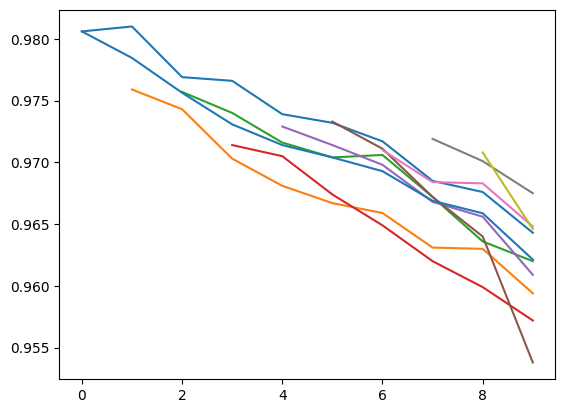

In [ ]:
permutedMNIST(100, 200, 'centre', 1)

# Split MNIST

In [ ]:
splitMNIST(120, 0, 'random', 0)

Task 1


Epochs:   4%|▍         | 5/120 [00:05<01:57,  1.02s/it, Loss: 50.1886, Acc: 1.0000]


KeyboardInterrupt: 

In [ ]:
splitMNIST(120, 40, 'random', 0)

In [ ]:
splitMNIST(120, 40, 'centre', 0)

In [ ]:
splitMNIST(120, 0, 'random', 1)

In [ ]:
splitMNIST(120, 40, 'random', 1)

In [ ]:
splitMNIST(120, 40, 'centre', 1)

# Split notMNIST

In [ ]:
splitnotMNIST(120, 0, 'random', 0)

In [ ]:
splitnotMNIST(120, 40, 'random', 0)

In [ ]:
splitnotMNIST(120, 40, 'centre', 0)

In [ ]:
splitnotMNIST(120, 0, 'random', 1)

In [ ]:
splitnotMNIST(120, 40, 'random', 1)

In [ ]:
splitnotMNIST(120, 40, 'centre', 1)